In [62]:
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import data
from models import MobileModel

import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


## Model

In [31]:
model = torchvision.models.shufflenet_v2_x1_0()
model.fc = nn.Linear(1024, 2)
model.load_state_dict(torch.load('weights/shufflenet_v2_x1_0_fp16.pth'))

model.eval();

## Data

In [15]:
crop_size = 160
val_transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(*data.IMAGENET_STATS)
    ])

In [19]:
mobile_model = MobileModel.load_from_checkpoint(
    'lightning_logs/shufflenet_v2_x1_0/version_0/checkpoints/epoch=1.ckpt')

In [21]:
mobile_model.prepare_data()
test_dl = mobile_model.test_dataloader()

Dataset loading..
Before downsampling
0.0    189406
1.0     13193
Name: label, dtype: int64
After downsampling
0.0    47352
1.0    13193
Name: label, dtype: int64


## Predict test set

In [45]:
y_true = []
y_pred = []
for batch in tqdm.tqdm(test_dl):
    x, y = batch
    y_true.append(y.numpy())
    
    with torch.no_grad():
        pred = torch.argmax(model(x), 1)
        y_pred.append(pred.numpy())

y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)

100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


### Sanity check of accuracy

In [49]:
(y_true == y_pred).mean()

0.9920726672171759

## Visualization

In [64]:
incorrect_idxs = np.nonzero(y_true != y_pred)[0]

In [60]:
def imshow(inp, title=None, figsize=(5, 5)):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(data.IMAGENET_STATS[0])
    std = np.array([data.IMAGENET_STATS[1]])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


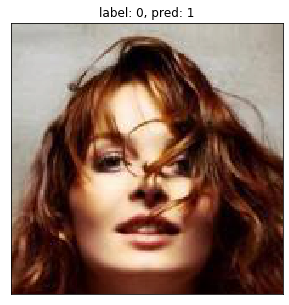

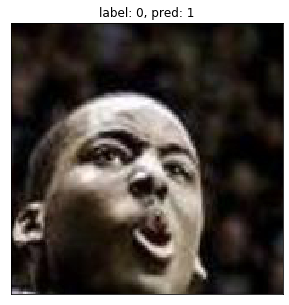

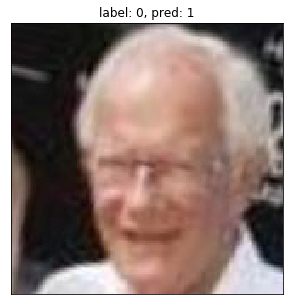

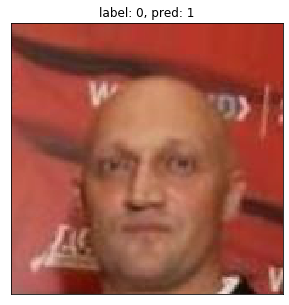

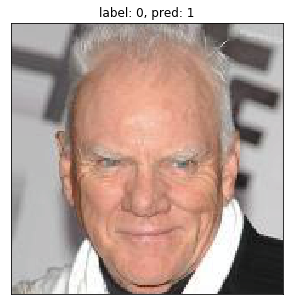

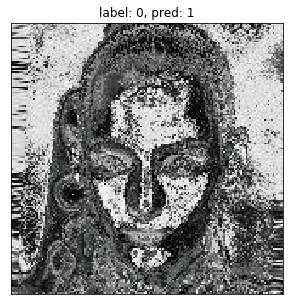

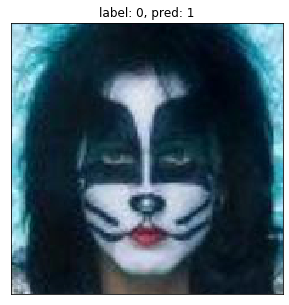

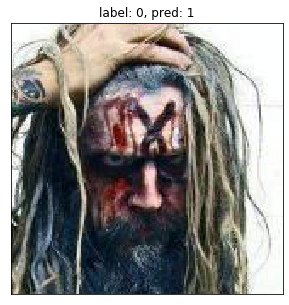

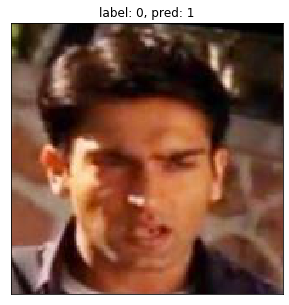

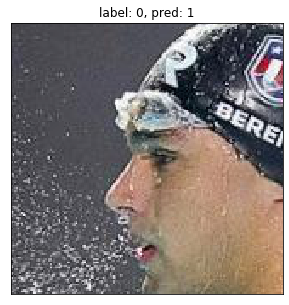

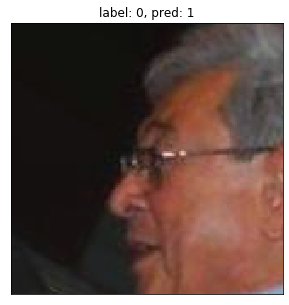

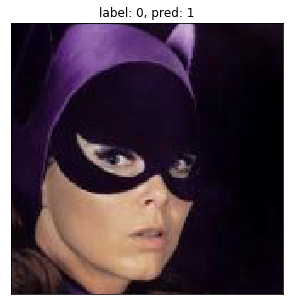

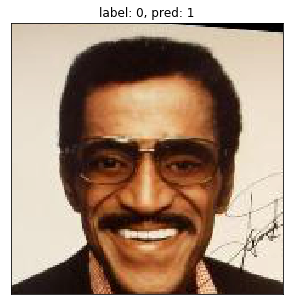

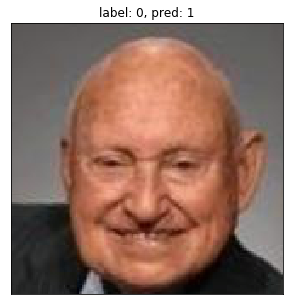

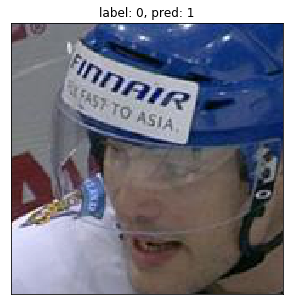

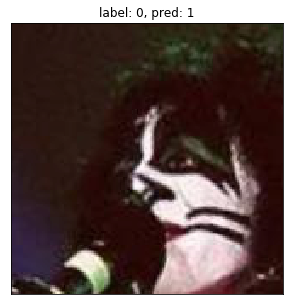

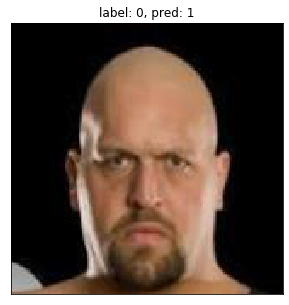

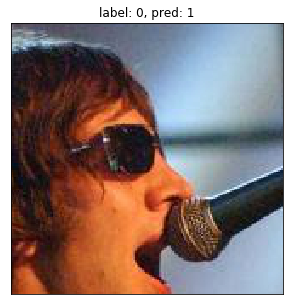

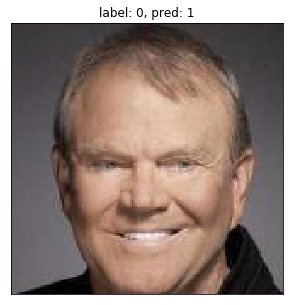

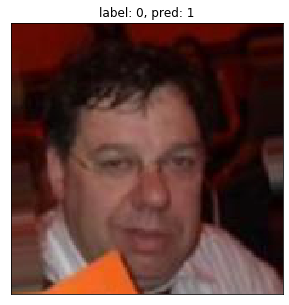

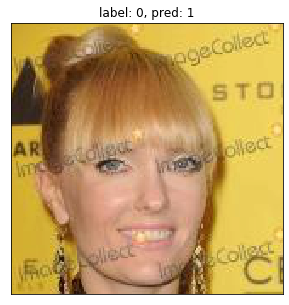

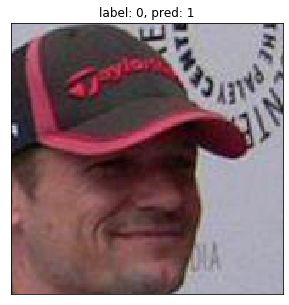

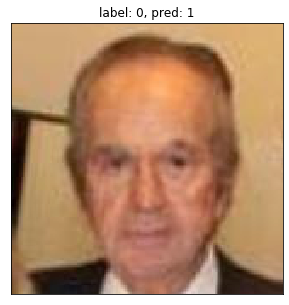

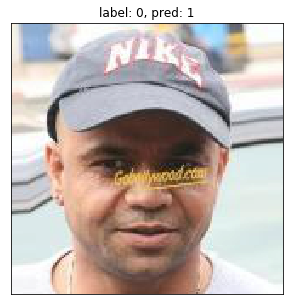

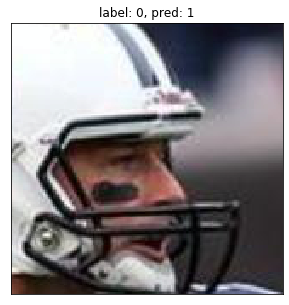

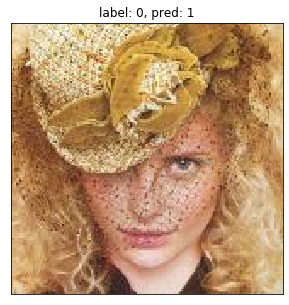

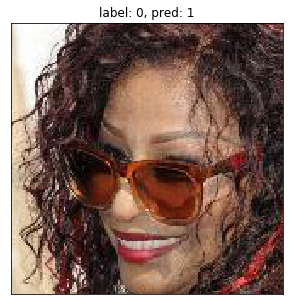

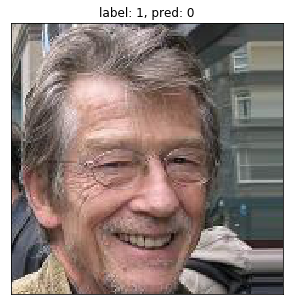

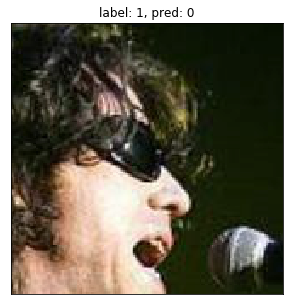

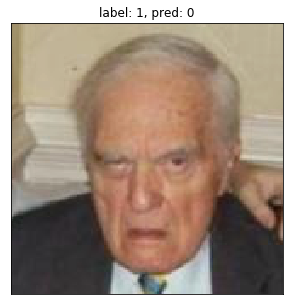

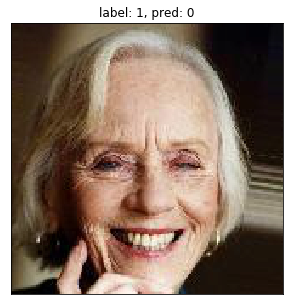

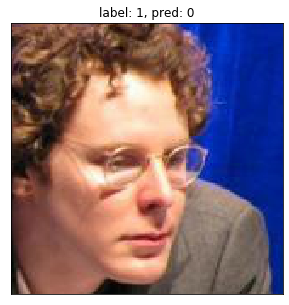

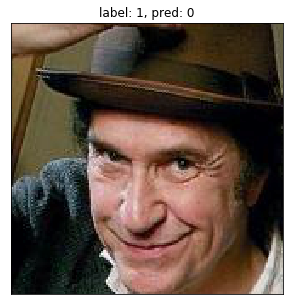

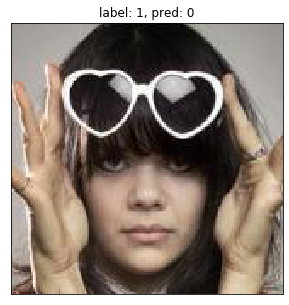

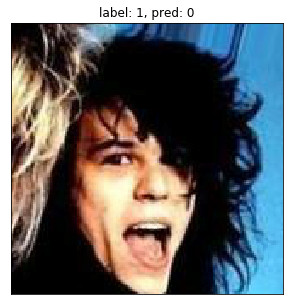

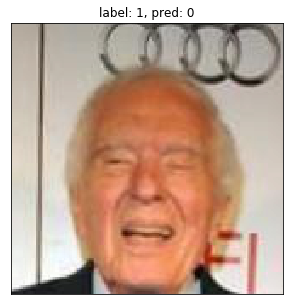

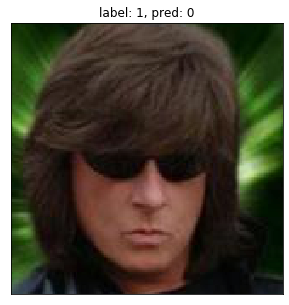

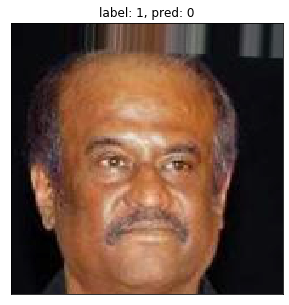

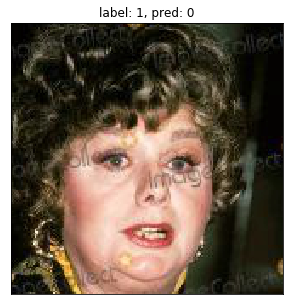

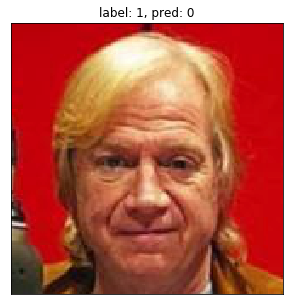

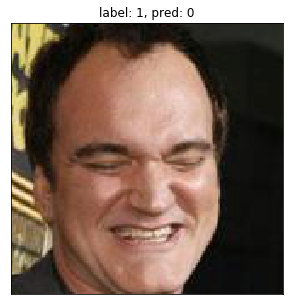

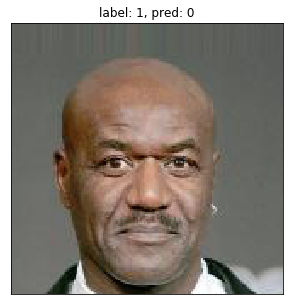

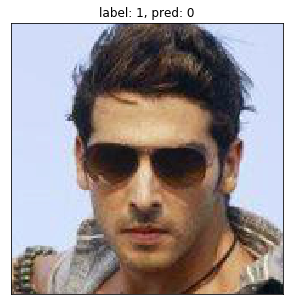

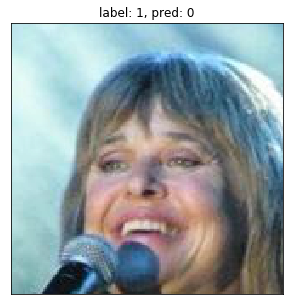

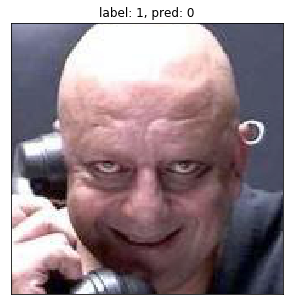

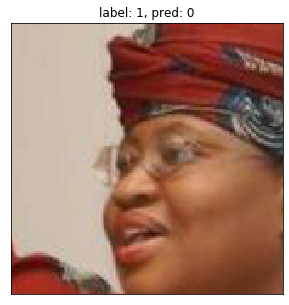

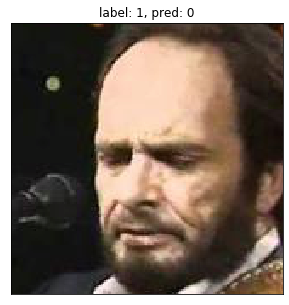

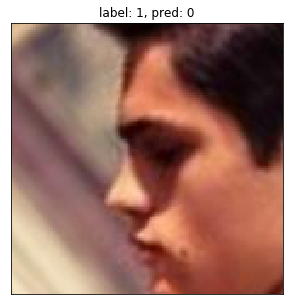

In [68]:
for idx in incorrect_idxs:
    img, label = mobile_model.test_dataset[idx]
    pr = y_pred[idx]
    imshow(img, f'label: {label}, pred: {pr}')

We can see some errors in dataset labels